# **Modelling and Evaluation**

## Objectives

* Business requirtement 2 will be addressed: Determining if a given leaf is infected with powdery mildew or not.

## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/validation
* Image shape embeddings

## Outputs

* Image distribution plot in train, validation, and test set.
* Label & set distribution.
* Image augmentation.
* Class indices to change prediction inference in labels.
* ML model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pkl file.
* Prediction on the random image file.

## Additional Comments

* In this notebook an ML model will be developed and trained using the train and validation sets. It will then be evaluated using the test set to determine if Business Requirement 2 is been met.


---

# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set working directory

Confirm the new current directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspaces/cherryleafmildewdetector-ci-project5')
print('You set a new working directory')

You set a new working directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/cherryleafmildewdetector-ci-project5'

---

### Set input directories

Set paths for train, test and validation sets

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir +
                                                               '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set Label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


### Set image shape

Import saved image shape embedding

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(160, 160, 3)

---

## Number of images in each set

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




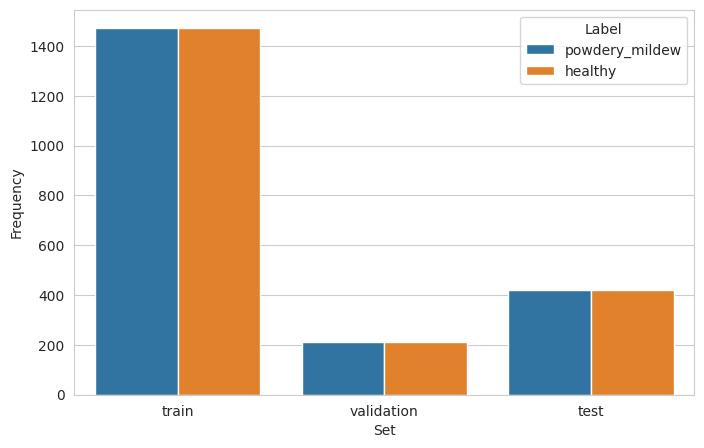

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder +
                                            '/' + label)))
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir + '/' + folder
                                                    + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Set Distribution - Pie Chart

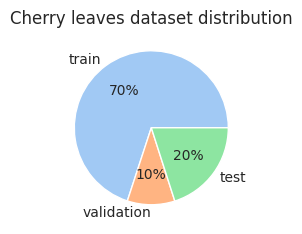

In [10]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry leaves dataset distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

Import ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-31 16:29:43.864443: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 16:29:43.897860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialise ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment Image sets

#### Train

In [13]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Validation

In [14]:
validation_set = ImageDataGenerator(
    rescale=1./255).flow_from_directory(val_path,
                                        target_size=image_shape[:2],
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False
                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Test

In [15]:
test_set = ImageDataGenerator(
    rescale=1./255).flow_from_directory(test_path,
                                        target_size=image_shape[:2],
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False
                                        )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

---

### Plot Augmented Images

### Training

(20, 160, 160, 3)


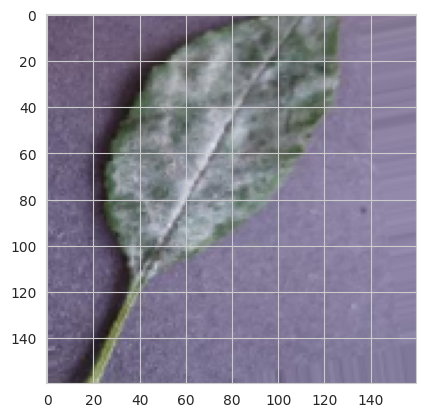

(20, 160, 160, 3)


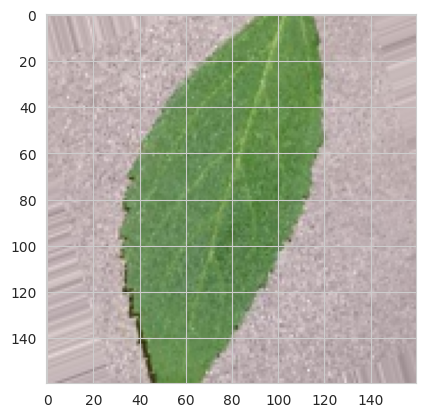

(20, 160, 160, 3)


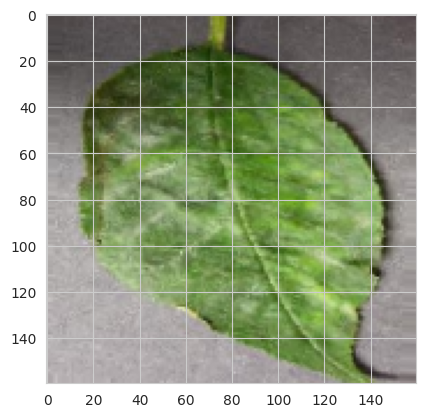

In [16]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Validation

(20, 160, 160, 3)


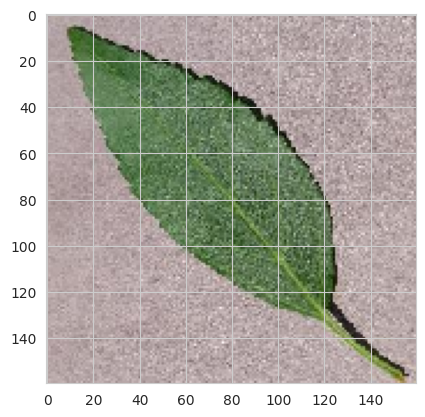

(20, 160, 160, 3)


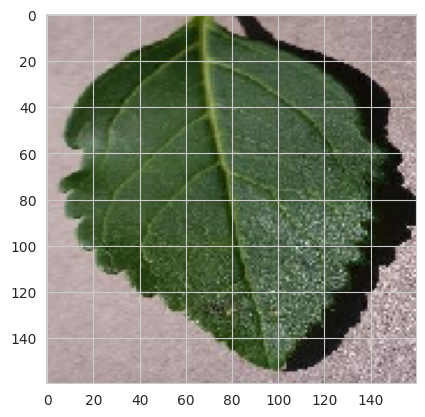

(20, 160, 160, 3)


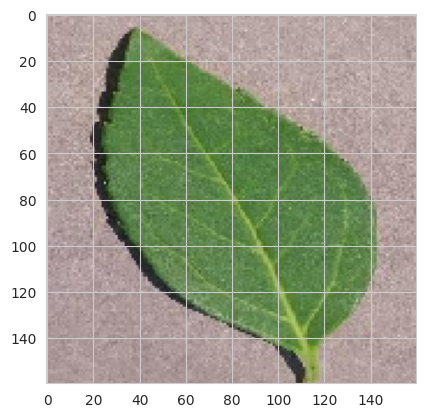

In [17]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Test

(20, 160, 160, 3)


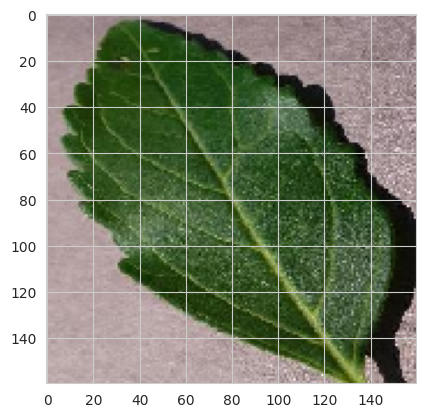

(20, 160, 160, 3)


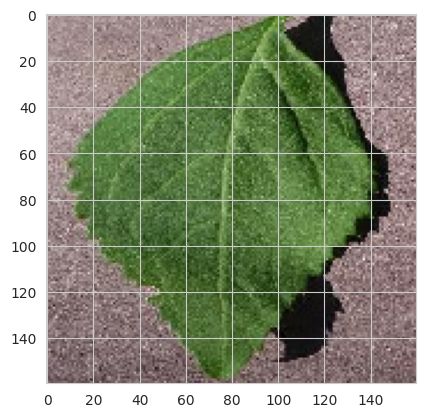

(20, 160, 160, 3)


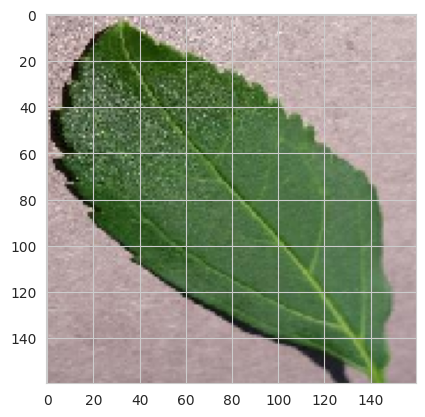

In [18]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

---

## Model Creation

### Import packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Create model


In [21]:
def create_tf_model():
    """
    Function creates the ML model
    """
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### ML model summary

In [22]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,914 (10.34 MB)

 Trainable params: 2,710,914 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

### Early Stopping

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit ML model

In [24]:
model = create_tf_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 327ms/step - accuracy: 0.7999 - loss: 0.4093 - val_accuracy: 0.9238 - val_loss: 0.1606
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - accuracy: 0.9000 - loss: 0.2544

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9000 - loss: 0.2544 - val_accuracy: 0.9571 - val_loss: 0.1260
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 52s 350ms/step - accuracy: 0.9665 - loss: 0.1104 - val_accuracy: 0.9952 - val_loss: 0.0269
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 0.0474 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.9740 - loss: 0.0768 - val_accuracy: 0.9976 - val_loss: 0.0152
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 1.0000 - loss: 0.0432 - val_accuracy: 0.9976 - val_loss: 0.0122
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 317ms/step - accuracy: 0.9891 - loss: 0.0307 - val_accuracy: 1.0000 - val_loss: 2.4717e-04
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 1.3356e-04
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 78s 309ms/step - accuracy: 0.9877 - loss: 0.0366 - val

### Save model

In [25]:
model.save('outputs/v2/powdery_mildew_model.h5')

---

## ML model Performance

### Learning Curve

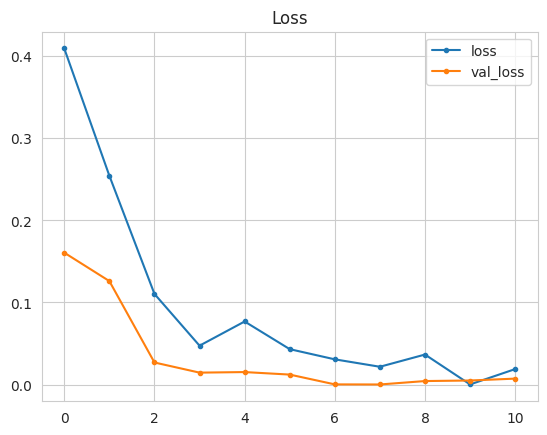

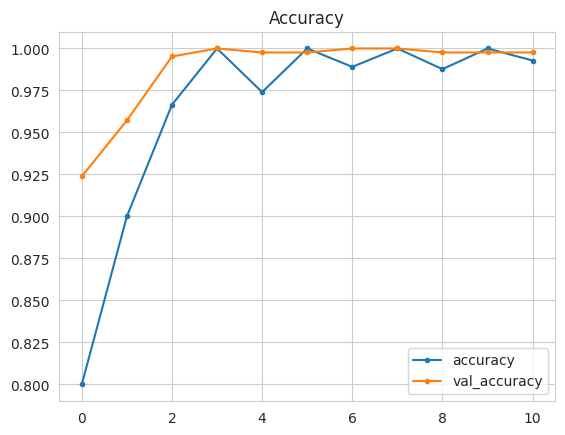

In [26]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=125)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=125)
plt.show()

## Model Evaluation

#### Load Model

In [27]:
from keras.models import load_model
model = load_model('outputs/v2/powdery_mildew_model.h5')

#### Evaluate on test set

In [28]:
evaluation = model.evaluate(test_set)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9976 - loss: 0.0106


The performance on the test set meets the project requirements (at least 97% accuracy on test set) and answers Business Requirement #2

#### Save Evaluation pkl file

In [29]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2/evaluation.pkl")

['outputs/v2/evaluation.pkl']

## Evaluate on new data

#### Load random image as PIL

Image shape: (160, 160), Image mode: RGB


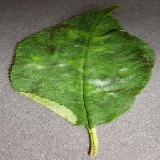

In [61]:
from tensorflow.keras.preprocessing import image

pointer = 50
label = labels[0] # select 0 for 'powdery_mildew' or 1 for 'healthy'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=(160, 160, 1), color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array and prepare for prediction

In [62]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 160, 160, 3)


#### Predict Class probabilities

In [63]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class}, {round(pred_proba*100, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
powdery_mildew, 99.98%
